In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

In [ ]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## Example image

## Selecting objects with SAM

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

## yolo loading

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone

In [ ]:
%cd yolov5
%pip install -qr requirements.txt  # install


In [ ]:
model = torch.hub.load(f'/content/yolov5', 'custom', source='local', path='/content/drive/MyDrive/tata_comms/best.pt', force_reload=True)   ### setting up confidence threshold


In [ ]:
def detectx (frame, model):
    frame = [frame]
    print(f"[INFO] Detecting. . . ")
    results = model(frame)

    # print(f'results:{results}')

    labels, cordinates = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]

    return labels,cordinates


In [ ]:
def plot_boxes(results,frame):

    labels, cord = results

    lb=labels.tolist()

    coords=cord.tolist()

    print(f'labels:{lb}')

    # print(f'coords---{(coords)}')

    string_labels=[]

    for x in lb:
        if x==0:
            string_labels.append('central_hub')
        elif x==1:
            string_labels.append('outer_clip')
        elif x==2:
            string_labels.append('inner_clip')
        elif x==3:
            string_labels.append('torsion_spring')
        elif x==4:
            string_labels.append('rivet_inner')
        elif x==5:
            string_labels.append('stop_pin')
        elif x==6:
            string_labels.append('rivet_top')
        elif x==7:
            string_labels.append('rivet_bottom')

    n = len(string_labels)

    x_shape, y_shape = frame.shape[1], frame.shape[0]

    print(f"[INFO] Total {n} detections. . . ")
    print(f"[INFO] Looping through all detections. . . ")


    labels_dict={}


    # if len(indices)>0:

    for i in range(n):
        row=coords[i]
        label=string_labels[i]
        if row[4]>0.75:
            x1, y1, x2, y2 = int(row[0]*x_shape), int(row[1]*y_shape), int(row[2]*x_shape), int(row[3]*y_shape)
            if len(labels_dict)==0 or label not in labels_dict.keys():
                labels_dict[label]=[]
                labels_dict[label].append([x1,y1,x2,y2])

            else:
                labels_dict[label].append([x1,y1,x2,y2])

            # cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # print(f'bboxcoords:{labels_dict}')

    # print(f'length---{len(labels_dict)}')

    # print(f'person_coords---{labelled_coords}')


    return frame,labels_dict


In [ ]:
img_dir='/content/drive/MyDrive/tata_comms/tata_images'
save_dir='/content/drive/MyDrive/tata_comms/results'

In [ ]:
for img in os.listdir(img_dir):
  frame=cv2.imread(img_dir+'/'+img)
  frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)        
  results = detectx(frame, model = model)
  result_image,labels_dict = plot_boxes(results,frame)
  predictor.set_image(frame)

  count=1
  classes=['central_hub','outer_clip','rivet_inner','torsion_spring']

  for key,value in labels_dict.items():
    if key=='central_hub' or key=='outer_clip' or key=='rivet_inner' or key=='torsion_spring':
      
      input_boxes=torch.tensor(value,device=predictor.device)

      transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, frame.shape[:2])

      masks, _, _ = predictor.predict_torch(
      point_coords=None,
      point_labels=None,
      boxes=transformed_boxes,
      multimask_output=False,)

      new_masks=masks.cpu().numpy().astype('uint8')

      combined_mask=np.zeros(frame.shape[:-1],dtype='uint8')
      print(combined_mask.shape)
      for mask in new_masks:
        combined_mask+=mask[0]

      combined_mask=combined_mask*255
      os.makedirs(f"/content/drive/MyDrive/tata_comms/results/{img.split('.')[0]}",exist_ok=True)

      cv2.imwrite(f"/content/drive/MyDrive/tata_comms/results/{img.split('.')[0]}/{classes.index(key)}.png",combined_mask)
      print(count)
      count+=1    



In [ ]:
# frame = cv2.imread('/content/drive/MyDrive/tata_comms/1.bmp')
# frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)        
# results = detectx(frame, model = model) ### DETECTION HAPPENING HERE    


In [ ]:
# resulting_frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)

# result_image,labels_dict = plot_boxes(results,frame)

In [ ]:
labels_dict

In [ ]:
count=1

for key,value in labels_dict.items():
  if key=='central_hub' or key=='outer_clip' or key=='rivet_inner' or key=='torsion_spring':
    
    input_boxes=torch.tensor(value,device=predictor.device)

    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, frame.shape[:2])

    masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,)

    new_masks=masks.cpu().numpy().astype('uint8')

    combined_mask=np.zeros((1944,2592),dtype='uint8')
    print(combined_mask.shape)
    for mask in new_masks:
      combined_mask+=mask[0]

    combined_mask=combined_mask*255
    
    cv2.imwrite(f'/content/drive/MyDrive/tata_comms/results/{count}.png',combined_mask)
    print(count)
    count+=1    



(1944, 2592)
1
(1944, 2592)
2
(1944, 2592)
3
(1944, 2592)
4


In [ ]:
# image = cv2.imread('/content/drive/MyDrive/tata_comms/1.bmp')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
# plt.figure(figsize=(10,10))
# plt.imshow(image)
# plt.axis('on')
# plt.show()

In [ ]:
# predictor.set_image(frame)

## Specifying a specific object with a box

The model can also take a box as input, provided in xyxy format.

In [ ]:
labels_dict['rivet_inner']

[[913, 530, 999, 620],
 [1611, 1225, 1695, 1315],
 [918, 1233, 1003, 1322],
 [1613, 530, 1700, 622]]

In [ ]:
input_boxes=torch.tensor(labels_dict['rivet_inner'],device=predictor.device)

In [ ]:
# input_box = np.array([425, 600, 700, 875])

# input_box = np.array([909,526,1005,622],[1096,365,1483,616])

# input_boxes = torch.tensor([
#     [909,526,1005,622],
#     [1096,365,1483,616]
# ], device=predictor.device)



In [ ]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, frame.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)


In [ ]:
# masks, _, _ = predictor.predict(
#     point_coords=None,
#     point_labels=None,
#     box=input_box[None, :],
#     multimask_output=False,
# )

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(frame)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

In [ ]:
new=masks.cpu().numpy().astype('uint8')

In [ ]:
# new[new==True]=1new[new==False]=0


In [ ]:
# print(np.unique(new.astype('uint8'),return_counts=True))

In [ ]:
combined_mask=np.zeros((1944,2592),dtype='uint8')
print(combined_mask.shape)
for mask in new:
  combined_mask+=mask[0]




(1944, 2592)


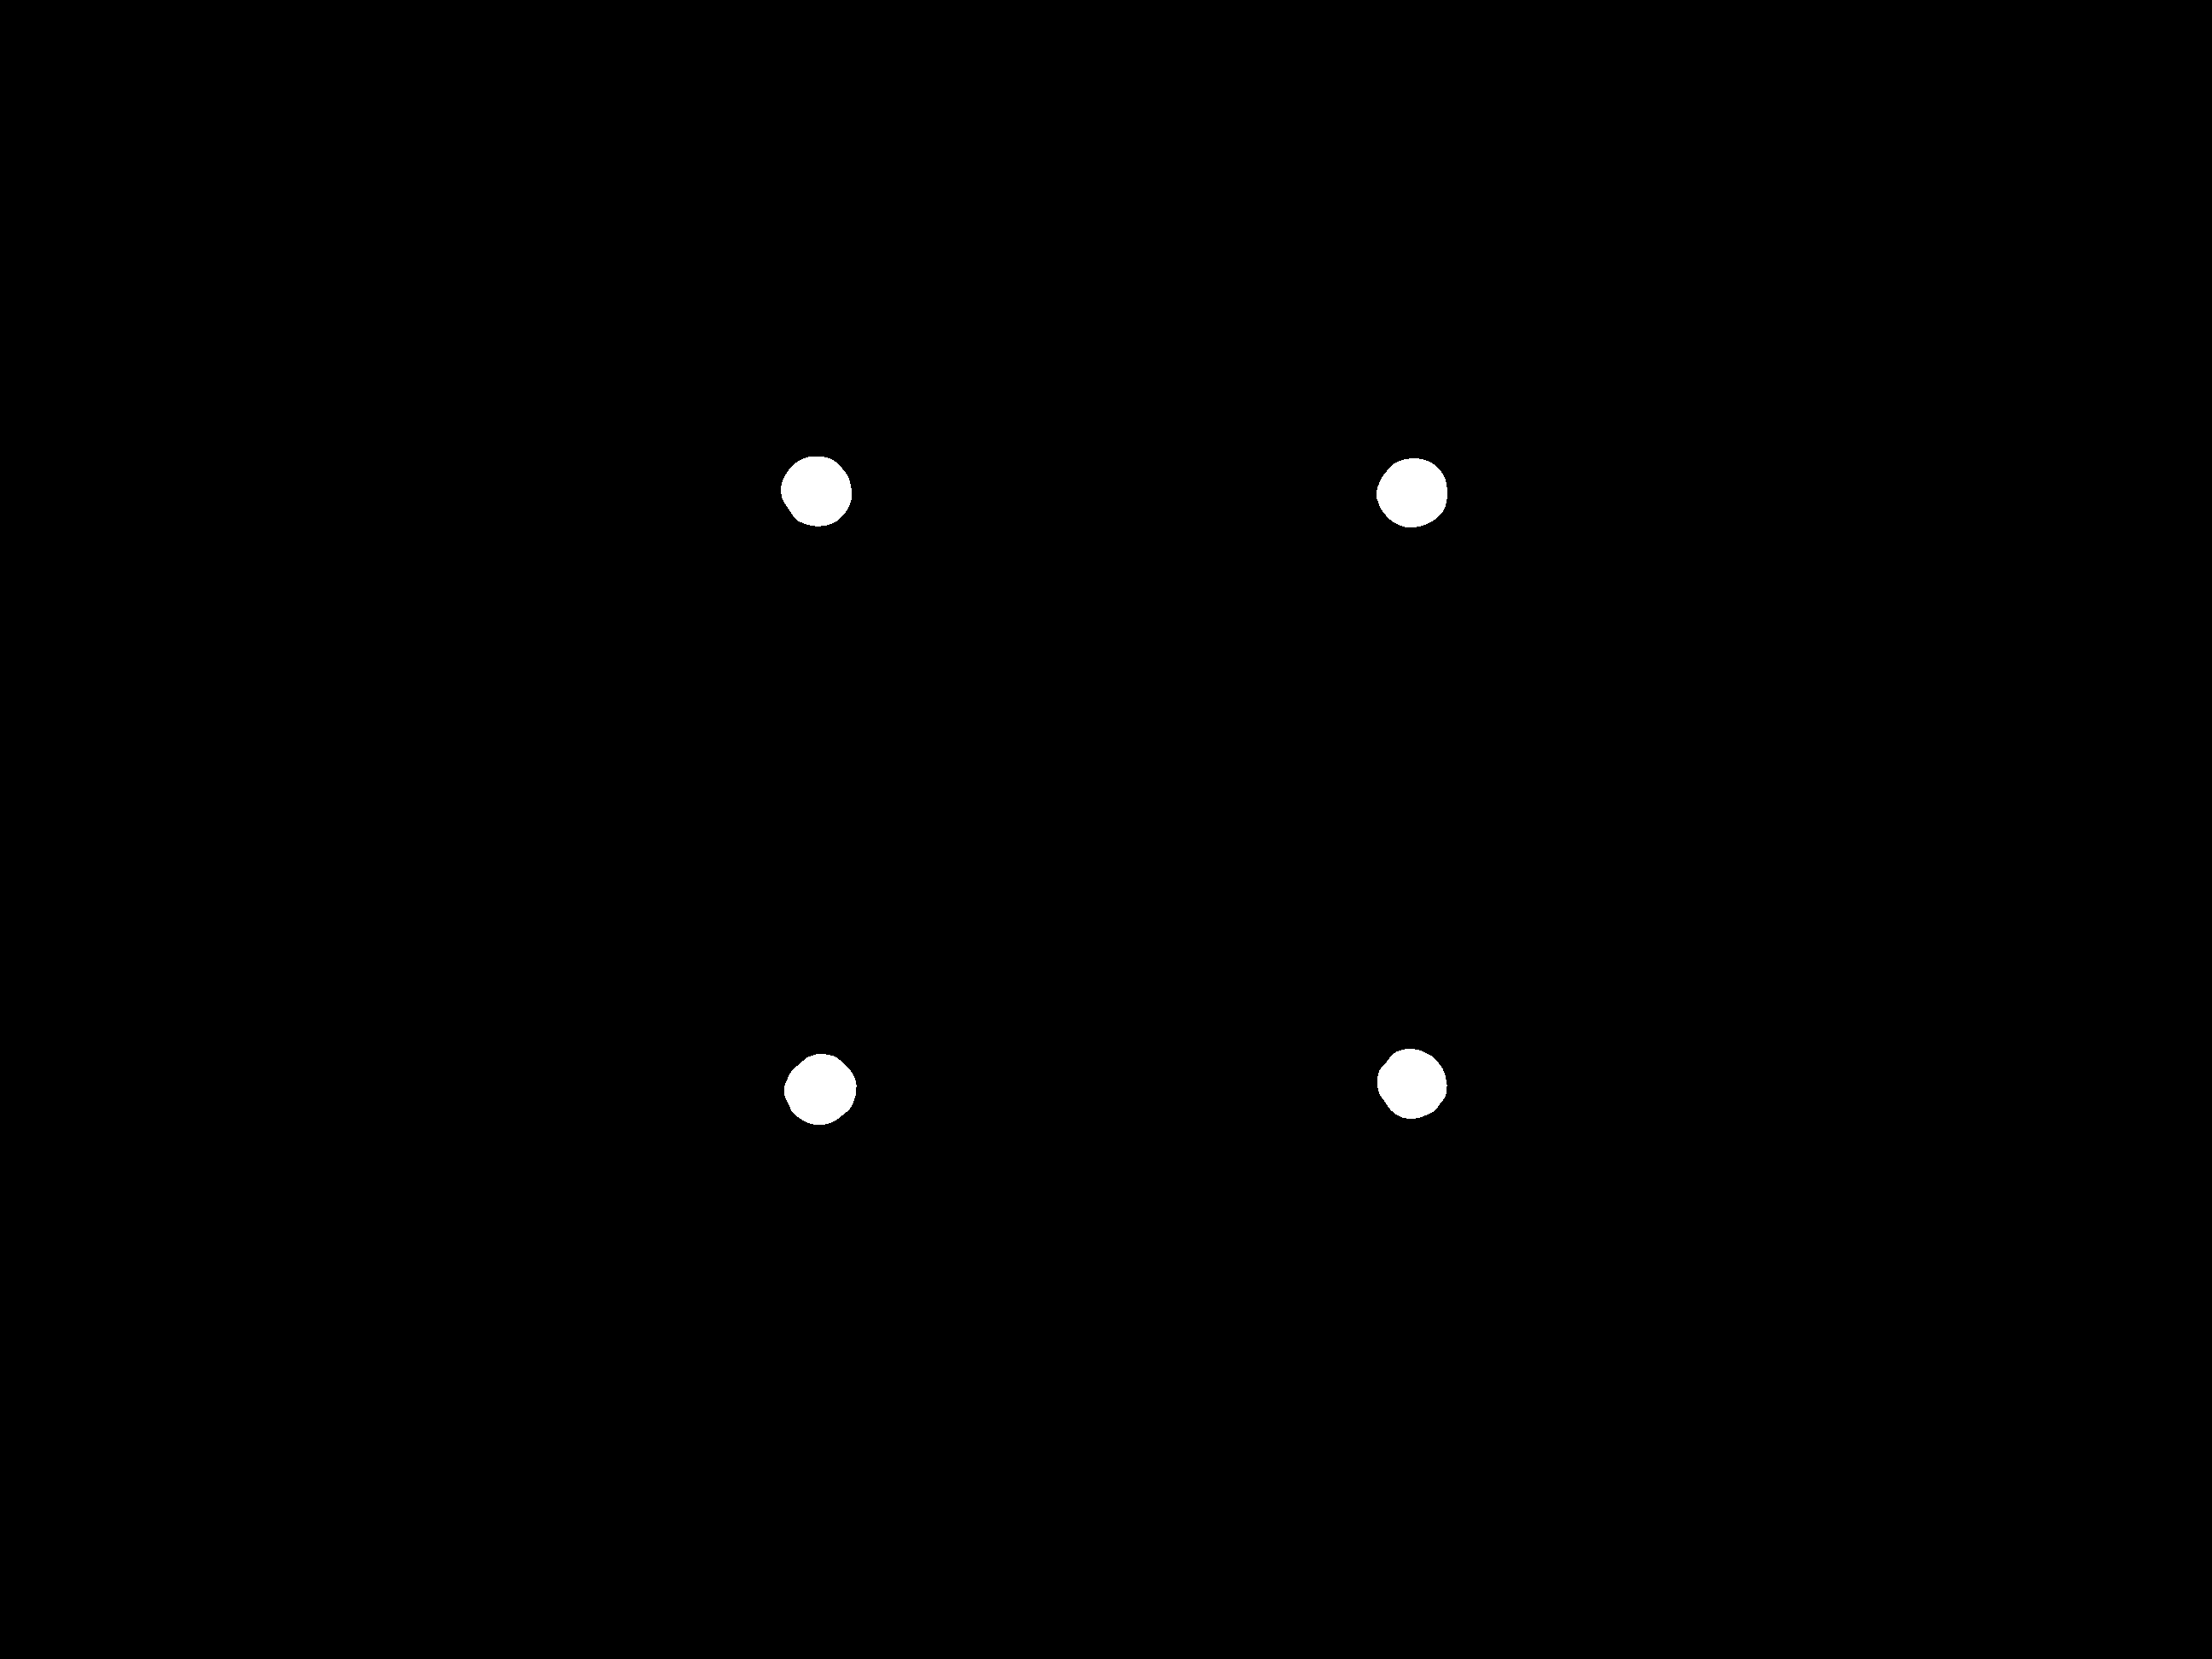

In [ ]:
cv2_imshow(combined_mask*255)

In [ ]:
cv2.imwrite('new.png',new)

False

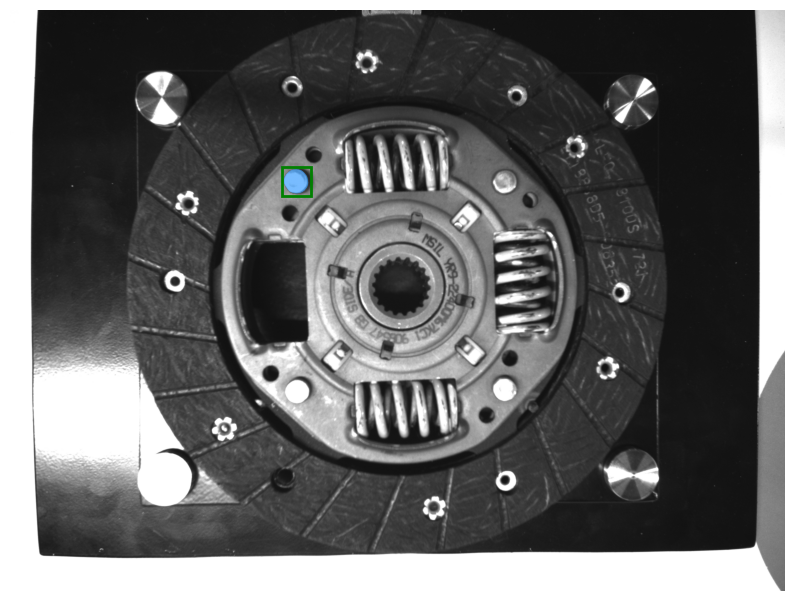

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

Run the model.